In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import multiprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):  
    def training_step(self, batch):  
        images, labels = batch
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss

    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}

    def validating_epoch_final(self, outputs):
        batch_loss = [x['Validation Loss'] for x in outputs] 
        # each batch of the validation data
        epoch_loss = torch.stack(batch_loss).mean() 
        batch_accuracy = [x['Validation Accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))

In [3]:
class ResNet(ImageClassification):
    def __init__(self):
        super().__init__()
        # Using ResNet50 pretrained model
        self.network = models.resnet50(weights="ResNet50_Weights.DEFAULT")
        features = self.network.fc.in_features
        self.network.fc = nn.Linear(features, len(garbage_classes))

    def forward(self, image):
        return torch.sigmoid(self.network(image))

    def training_step(self, batch):
        images, labels = batch  
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Train Loss'], result['Validation Loss'], result['Validation Accuracy']))

In [4]:
def export_classification_metrics(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)
            labels = labels.to(device)  
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    for i, class_name in enumerate(classes):
        class_labels = [1 if label == i else 0 for label in all_labels]
        class_preds = [1 if pred == i else 0 for pred in all_preds]
        
        accuracy = accuracy_score(class_labels, class_preds) * 100
        precision = precision_score(class_labels, class_preds, zero_division=0) * 100
        recall = recall_score(class_labels, class_preds, zero_division=0) * 100
        f1 = f1_score(class_labels, class_preds, zero_division=0) * 100
        
        print(f'{class_name}, accuracy: {accuracy:.2f}%, precision: {precision:.2f}%, recall: {recall:.2f}%, F1 score: {f1:.2f}%')

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, restore_best_weights=True):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_weights = model.state_dict().copy()
            if self.verbose:
                print(f'Validation loss improved: {val_loss:.4f}')
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve: {val_loss:.4f}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_weights is not None:
                    model.load_state_dict(self.best_model_weights)
                    if self.verbose:
                        print("Restored best model weights.")

In [6]:
def plot_accuracy_per_class(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())

    accuracies = []
    for i, class_name in enumerate(classes):
        class_labels = [1 if label == i else 0 for label in all_labels]
        class_preds = [1 if pred == i else 0 for pred in all_preds]

        accuracy = accuracy_score(class_labels, class_preds) * 100
        accuracies.append(accuracy)

    plt.bar(classes, accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
directory = '/kaggle/input/trashnet/dataset-resized'
global garbage_classes
garbage_classes = os.listdir(directory)
print(garbage_classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Resize the image to 224x224 pixels and transform into Tensor
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load the dataset and apply transformations
dataset = ImageFolder(directory, transform=transformations)

Label: paper (Class No: 3)


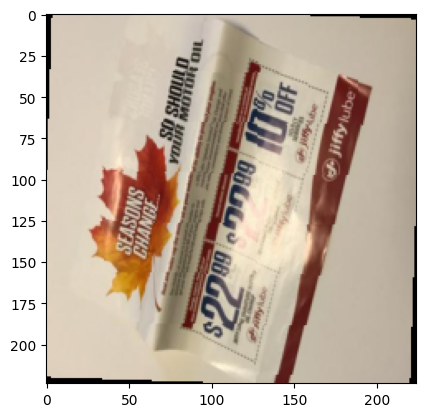

In [9]:
def display_test(image, label):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Displays random images from the dataset
image, label = dataset[random.randint(0, len(dataset))]
display_test(image, label)

In [10]:
random_seed = 43
torch.manual_seed(random_seed)

In [11]:
train_size = int(0.6 * len(dataset))  
val_size = int(0.2 * len(dataset))  
test_size = len(dataset) - train_size - val_size  
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
from torch.utils.data.dataloader import DataLoader
batch_size = 64

**SET UP DATALOADERS**

In [12]:
train = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation = DataLoader(val_data, batch_size * 2, num_workers=4, pin_memory=True)

**BATCH VISUALIZATION**

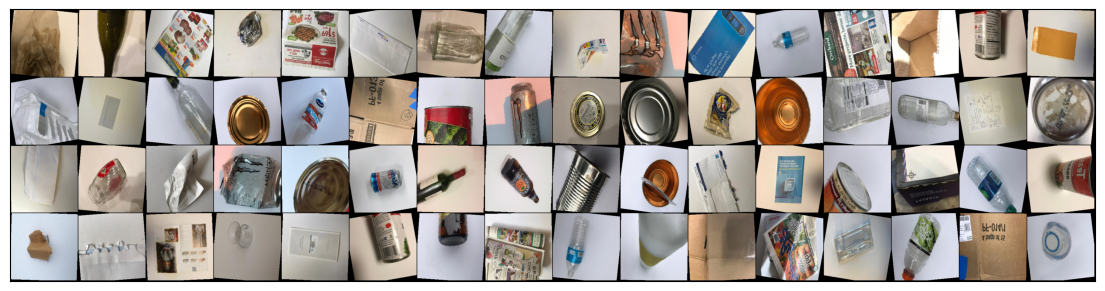

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


Processing via: cuda


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [13]:
from torchvision.utils import make_grid
def batch_visualization(data):
    for image, labels in data:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        plt.show()
        break

batch_visualization(train)
model = ResNet()

# Port model GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

# Convert model to GPU
def move_to_gpu(data, device):
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking=True)

# DataLoading Class
class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()

    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)

    def __len__(self):
        return len(self.data)

device = get_default_device()
print('Processing via:', device)  # Note: Nếu output trả về cuda, thì có thể thực hiện huấn luyện qua GPU

train = DataLoad(train, device)
validation = DataLoad(validation, device)
move_to_gpu(model, device)

In [14]:
@torch.no_grad()
def evaluate(model, validator):
    model.eval()
    outputs = [model.validating(batch) for batch in validator]
    return model.validating_epoch_final(outputs)

def opt(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD, patience = 5):
    training_history = []  # List dùng để chứa lịch sử huấn luyện
    optimizer = opt_func(model.parameters(), learning_rate)
    early_stopping = EarlyStopping(patience=patience, verbose=True)  # Thiết lập early stopping

    for epoch in range(epochs):
        model.train()  
        train_loss = []  # List dùng để lưu training loss
        for batch in train_loader:
            loss = model.training_step(batch)  # Tính toán độ loss
            train_loss.append(loss)  # Thêm loss vào danh sách
            loss.backward()  # Thực hiện truyền ngược (Backpropagate)
            optimizer.step()  # Cập nhật các tham số bằng cách sử dụng optimizer
            optimizer.zero_grad()  # Đặt lại gradient về 0 cho batch tiếp theo

        # Giai đoạn Validation
        result = evaluate(model, validator)  # Đánh giá mô hình trên tập xác thực
        result['Train Loss'] = torch.stack(train_loss).mean().item()  # Tinh toán trung bình của training loss
        model.epoch_final(epoch, result)  # Gọi phương thức epoch_final trên mô hình
        training_history.append(result)  # Thêm kết quả vào lịch sử huấn luyện
        
        # Kiểm tra early stopping
        early_stopping(result['Validation Loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break  # Dừng việc huấn luyện nếu thỏa điều kiện kích hoạt early stopping

    return training_history

model = move_to_gpu(ResNet(), device)
evaluate(model, validation)

{'Validation Loss': 1.786719799041748,
 'Validation Accuracy': 0.18814566731452942}

**SET UP HYPERPARAMETERS**

In [15]:
epoch = 50
optimizer = torch.optim.Adam
learning_rate = 0.00005
patience = 3  # Số epoch chờ để xem tình hình cải thiện của mô hình trước khi dừng huấn luyện
model_history = opt(epoch, learning_rate, model, train, validation, optimizer, patience)

Epoch [1], Training Loss: 1.7371, Validation Loss: 1.6630, Validation Accuracy: 0.6240
Validation loss improved: 1.6630
Epoch [2], Training Loss: 1.5737, Validation Loss: 1.4541, Validation Accuracy: 0.7866
Validation loss improved: 1.4541
Epoch [3], Training Loss: 1.4002, Validation Loss: 1.3056, Validation Accuracy: 0.8441
Validation loss improved: 1.3056
Epoch [4], Training Loss: 1.2786, Validation Loss: 1.2204, Validation Accuracy: 0.8755
Validation loss improved: 1.2204
Epoch [5], Training Loss: 1.1987, Validation Loss: 1.1780, Validation Accuracy: 0.9087
Validation loss improved: 1.1780
Epoch [6], Training Loss: 1.1529, Validation Loss: 1.1603, Validation Accuracy: 0.9148
Validation loss improved: 1.1603
Epoch [7], Training Loss: 1.1272, Validation Loss: 1.1390, Validation Accuracy: 0.9232
Validation loss improved: 1.1390
Epoch [8], Training Loss: 1.0988, Validation Loss: 1.1275, Validation Accuracy: 0.9369
Validation loss improved: 1.1275
Epoch [9], Training Loss: 1.0868, Valida

**DRAFT ACCURACY VS EPOCHS & LOSS VS EPOCHS CHART**

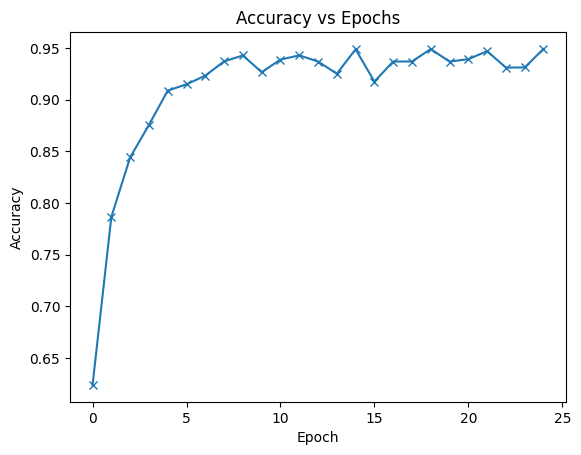

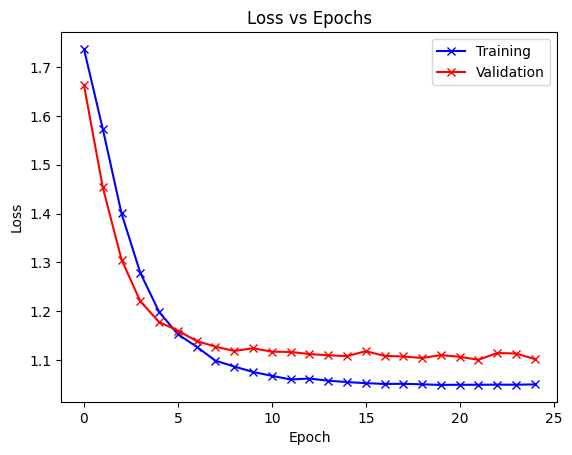

In [16]:
def plot_accuracy(model_history):
    accuracies = [x['Validation Accuracy'] for x in model_history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.show()
plot_accuracy(model_history)

def plot_loss(model_history):
    train_loss = [x.get('Train Loss') for x in model_history]
    validation_loss = [x['Validation Loss'] for x in model_history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Epochs')
    plt.show()
plot_loss(model_history)

**EXPORTS ACCURATE RESULTS AND PERFORMANCE PARAMETERS AMONG WASTE TYPES**

metal, accuracy: 99.41%, precision: 98.51%, recall: 97.06%, F1 score: 97.78%
glass, accuracy: 97.03%, precision: 95.04%, recall: 92.74%, F1 score: 93.88%
paper, accuracy: 98.02%, precision: 91.46%, recall: 96.15%, F1 score: 93.75%
trash, accuracy: 97.82%, precision: 94.92%, recall: 95.73%, F1 score: 95.32%
cardboard, accuracy: 96.83%, precision: 91.92%, recall: 91.92%, F1 score: 91.92%
plastic, accuracy: 98.22%, precision: 77.78%, recall: 73.68%, F1 score: 75.68%


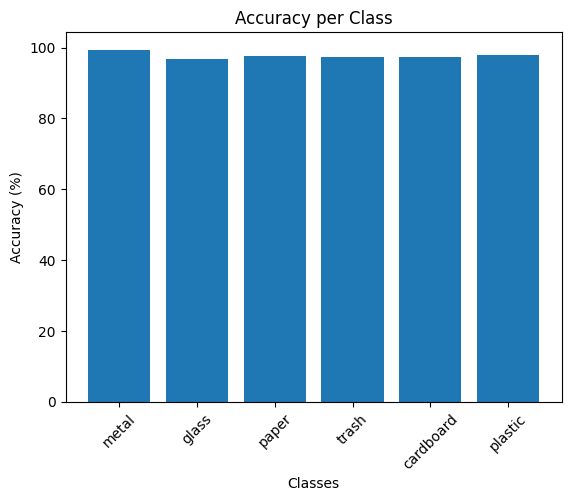

In [17]:
export_classification_metrics(model, validation, garbage_classes)
plot_accuracy_per_class(model, validation, garbage_classes)

**CONFUSION MATRIX**

<Figure size 1000x1000 with 0 Axes>

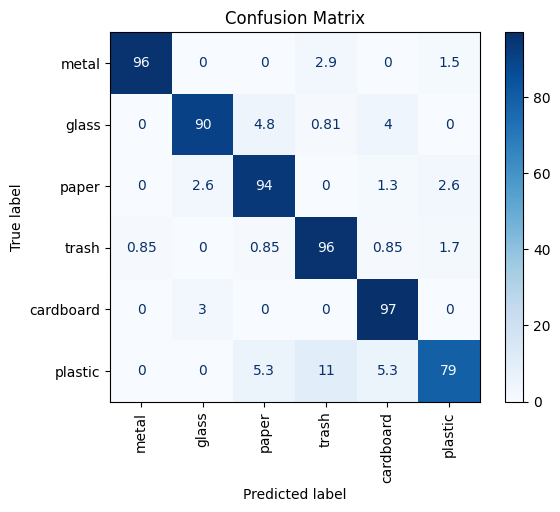

In [18]:
def plot_confusion_matrix(model, dataloader, classes):
    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    # Tạo confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to get percentages
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=classes)

    # Vẽ confusion matrix
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()
plot_confusion_matrix(model, validation, garbage_classes)

**VISUALIZATION OF PREDICTIONS**

In [19]:
def predict(image, model):
    xb = move_to_gpu(image.unsqueeze(0), device)
    # Nhận dự đoán từ mô hình
    yb = model(xb)
    # Chọn index với xác xuất cao nhất
    _, preds = torch.max(yb, dim=1)
    # Truy xuất class label
    return dataset.classes[preds[0].item()]

**TESTING NO.1**

Testing No.1 - Class: cardboard , Predicted Class: cardboard


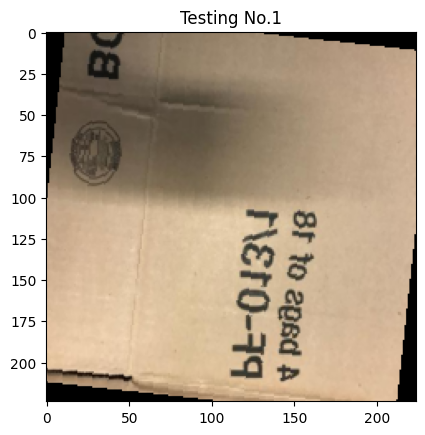

In [20]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Testing No.1 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.1')
plt.show()

**TESTING NO.2**

Testing No.2 - Class: cardboard , Predicted Class: cardboard


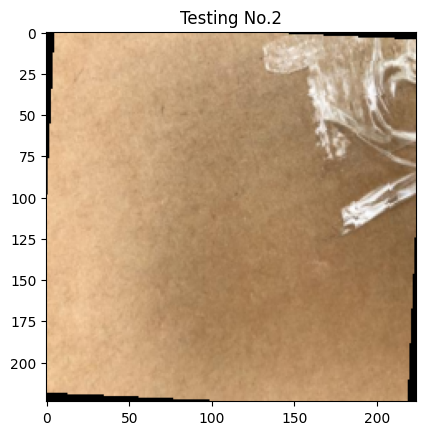

In [21]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Testing No.2 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.2')
plt.show()

**TESTING NO.3**

Testing No.3 - Class: trash , Predicted Class: trash


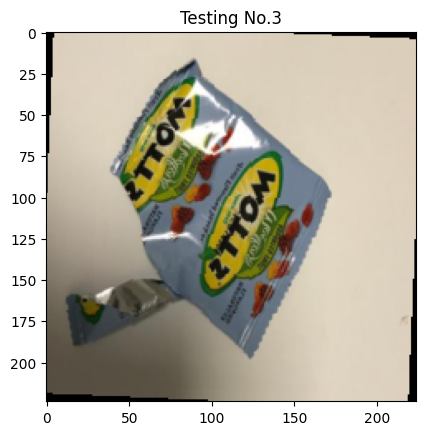

In [22]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0)) 
print('Testing No.3 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.3')
plt.show()

**SAVE MODEL**

In [23]:
FILE = "/kaggle/working/ResnetModel.pth"
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted, FILE)

**Wandb Logging**

In [25]:
# Import W&B
import wandb

# Initialize a new W&B run
wandb.init(project="trashnet-classification")

result = evaluate(model, validation)  # This should return a dictionary with metrics

# Log hyperparameters and other config
wandb.config.update({
    "epochs": epoch,  # Use the actual number of epochs from your training
    "batch_size": batch_size,  # Use the actual batch size
    "learning_rate": learning_rate  # Use the actual learning rate
})

# Log final metrics
wandb.log({
    "final_validation_loss": result['Validation Loss'],
    "final_validation_accuracy": result['Validation Accuracy']
})

# Optionally, log the model file as an artifact
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/kaggle/working/ResnetModel.pth')  # Path to your saved model
wandb.log_artifact(artifact)

# Finish the W&B run
wandb.finish()

final_validation_accuracy,▁
final_validation_loss,▁
final_validation_accuracy,0.93292
final_validation_loss,1.10767
